In [ ]:
import numpy as np
# np.seterr(all='raise')
np.seterr(under='ignore', invalid='raise', divide='raise', over='raise')
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl
from mpmath import zeta
from itertools import cycle
from functions import m_sv_interp, gstar_interp

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})


In [ ]:
Mpl = 1.2209e19
GSTAR = 90.0
GSTAR_S = 90.0

path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]
def gstar_interp(T):
    return np.interp(T, T_data, g_eff)

In [10]:
#####
# CONSTANTS
#######
# ----------------------------
# Constant values
# ----------------------------
GSTAR = 90.0
GSTAR_S = 90.0
ME = 0.000511e-3  # GeV
ALPHA_EM = 1.0/137.0
MPL   = 1.2209e19      # GeV
INCLUDE_HS_IN_H = True

# --- unit conversions: cm^3/s -> GeV^-2 ---
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3s_to_GeV2  = (cm_to_GeV_inv**3) / s_to_GeV_inv
Gev2_to_cm3s = 1.0 / cm3s_to_GeV2

In [ ]:
#####
# Model parameters and functions
#######

# ----------------------------
# Functions for cross sections
# ----------------------------
def gD_of_alpha(alphaD):           # g_D from alpha_D
    return np.sqrt(4.0*np.pi*alphaD)

def sigma_xx_to_AA(alphaD, mchi, mA):
    gD = gD_of_alpha(alphaD)
    r = mA / mchi
    amplitude = 16*gD**4 * (1 - r**2)/(9 * (r**2 - 2)**2)
    phase_space = 9 * np.sqrt(1 - r**2) / (64* np.pi * mchi**2)
    return amplitude * phase_space

def sigmav_chichi_ee(epsilon, alphaD, mchi, mA):
    # source: 2011.01240
    if mchi <= ME:
        return 0.0 # kinematically forbidden
    r   = mA / mchi
    e2  = 4.0*np.pi*ALPHA_EM
    gD  = gD_of_alpha(alphaD)
    pref = 4.0 * e2 * (epsilon**2) * (gD**2)
    num  = (2.0 + (ME**2)/(mchi**2))
    den  = (r**2 - 4.0)**2

    phase_space  = np.sqrt(1.0 - (ME**2)/(mchi**2)) / (8.0*np.pi*mchi**2)
    return pref * (num/den) * phase_space

def gammaA_ee(epsilon, mA):
    pref = epsilon**2 * ALPHA_EM / 3.0
    return pref * mA * (1 + 2*(ME**2)/(mA**2)) * np.sqrt(1 - 4*(ME**2)/(mA**2))

# ----------------------------

# ----------------------------
# Model parameters
# ----------------------------


In [48]:
mchi  = 10      # GeV
mA   = 2

alphaD = 1e-9
epsilon = 1e-7

gchi  = 2.0       # 2 dof
gA   = 3.0        # 3 dof

# ----------------------------

sv_xxff = sigmav_chichi_ee(epsilon, alphaD, mchi, mA)
sv_xxAA = sigma_xx_to_AA(alphaD, mchi, mA)


#sv_xxAA = sigmav_chichi_AA(alphaD, mchi, mA)
print("sigmav_xxff = ", sv_xxff , " cm^3/s")
print("sigmav_AAxx = ", sv_xxAA , " cm^3/s")

# ----------------------------
# convert units =
sv_xxff *= cm3s_to_GeV2
sv_xxAA *= cm3s_to_GeV2

#sv_xxAA *= cm3s_to_GeV2
print("sigmav_xxff = ", sv_xxff , " GeV^-2")
print("sigmav_AAxx = ", sv_xxAA , " GeV^-2")

sigmav_xxff =  2.3396932188431484e-27  cm^3/s
sigmav_AAxx =  3.0768375767315016e-20  cm^3/s
sigmav_xxff =  2.004311795877103e-10  GeV^-2
sigmav_AAxx =  0.0026357907948675804  GeV^-2


In [ ]:
# ----------------------------
# Entropy functions
# ----------------------------
def gstar_SM(T, t_dep = False):
    if t_dep:
        gstar_s = gstar_interp(T)
    else:
        gstar_s = GSTAR_S
    return  gstar_s
    #return GSTAR

def gstars_SM(T, t_dep = False):
    return gstar_SM(T, t_dep)
    #return GSTAR_S


def dln_gstars_SM_dlnT(T, t_dep = False, delta=1e-6):
    """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
    if t_dep:
        gstar_plus = gstar_interp(T * (1.0 + delta))
        gstar_minus = gstar_interp(T * (1.0 - delta))

    #return 0
        return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))
    else:
        return 0



# ----------------------------
# Helper thermo stuff
# ----------------------------

def H_of_T(T, rho_h=0.0, t_dep = False):
    """Hubble from SM  + HS """
    rho_SM = (np.pi**2/30.0) * gstar_SM(T, t_dep) * T**4
    if INCLUDE_HS_IN_H:
        rho_tot = rho_SM + rho_h
    else:
        rho_tot = rho_SM
    return np.sqrt((8.0*np.pi/3.0) * rho_tot) / MPL

def s_SM(T, t_dep = False):
    """SM entropy density"""
    return (2.0*np.pi**2/45.0) * gstars_SM(T, t_dep) * T**3


def dx_dt(T, m = mchi, t_dep = False):
    """dx/dt for x = mchi / T."""
    corr = 1.0 + (1.0/3.0) * dln_gstars_SM_dlnT(T, t_dep)
    return H_of_T(T, t_dep) * (m/T) / corr


def neq(m, g, T):
    """equilibrium number density at temperature T - use bessels"""
    x = m / T
    return g * (m**2*T) / (2.0*np.pi**2) * kv(2, x)

# def rho_i_exact(n_i, m_i, Th):
#     # source: 2504.00077, eqn 2.15
#     z = m_i / Th
#     # per-particle energy: m_i K1(z)/K2(z) + 3 Th (mass + kinetic)
#     return n_i * (m_i * kv(1, z) / kv(2, z) + 3.0 * Th)

def rho_i_exact(n_i, m_i, Th):
    # source: 2504.00077, eqn 2.15
    Th   = max(Th, VAL_FLOOR)        # avoid z = inf / division by zero
    z    = m_i / Th
    # Use scaled Kv: Kv(z) = e^{-z} kve(ν, z);  ratio is stable as kve(1)/kve(2)
    k2   = kve(2, z)
    ratio = kve(1, z) / max(k2, VAL_FLOOR)
    return n_i * (m_i * ratio + 3.0 * Th)

def P_i_exact(n_i, Th):
    # source: 2504.00077, eqn 2.15
    # MB equation of state is ideal-gas exactly: P = n T
    return n_i * Th

# def Q_elastic(T, Th, nchi, nf, alphaD, epsilon, mA, mchi):
#     sigmav = sigmav_deltaE(alphaD, epsilon, mA/mchi, mchi/T, T, Th)
#     return -sigmav*nf*nchi
#     #return 0.0  # placeholder

LOG_TINY = -745.0      # ~ log(np.finfo(float).tiny)
VAL_FLOOR = 1e-300     # generic positive floor

from scipy.special import kve

def safe_exp(logx):
    """exp(logx) with an underflow clamp to 0 (no NaNs/infs)."""
    return np.exp(np.maximum(logx, LOG_TINY))

def ln_neq(m, g, T):
    """
    ln n_eq = ln[g m^2 T /(2π^2)] + ln K2(m/T)
            = ln[g m^2 T /(2π^2)] + (-z + ln kve(2, z)),  z = m/T
    """
    z = m / T
    return (np.log(g) + 2*np.log(m) + np.log(T) - np.log(2*np.pi**2)
            - z + np.log(kve(2, z)))

# ----------------------------
# Collision terms
# ----------------------------

def collisions_old(params, nchi, gchi, nA, T, Th):
    # equilibrium distributions:

    gamma_Aee = params["gamma_Aee"]
    sv_xxee = params["sv_xxee"]
    sv_xxAA = params["sv_xxAA"]
    mchi = params["mchi"]
    mA = params["mA"]
    gA = params["gA"]
    gchi = params["gchi"]

    nchi_eq_SM = neq(mchi, gchi, T)
    nA_eq_SM = neq(mA,  gA, T)

    nA_eq_Th  = neq(mA,  gA,  Th)
    nchi_eq_Th = neq(mchi, gchi, Th)

    zA = mA / Th
    lorentz = kv(1, zA) / kv(2, zA)      # <m/E>_Th


    # number collision terms:
    C_chi = -0.5 * sv_xxee * (nchi**2 - nchi_eq_SM**2) \
            - sv_xxAA * (nchi**2  - (nchi_eq_Th**2 / nA_eq_Th**2) * nA**2)

    C_A  =  sv_xxAA * (nchi**2 - (nchi_eq_Th**2 / nA_eq_Th**2) * nA**2) \
           - gamma_Aee * lorentz * (nA - nA_eq_SM)


    Q_ann = - 0.5 * mchi * sv_xxee * (nchi**2 - nchi_eq_SM**2)

    ## decay contribution to energy transfer - lorentz factors cancel
    Q_dec = - mA * gamma_Aee * (nA - nA_eq_SM)  # use SM temp, final states are in eq with SM bath


    Q_h =  Q_ann + Q_dec # energy transfer to HS
    return C_chi, C_A, Q_h

def collisions(params, nchi, nA, T, Th):
    mchi = params["mchi"]; mA = params["mA"]
    gchi = params["gchi"]; gA = params["gA"]
    sv_xxee = params["sv_xxee"]; sv_xxAA = params["sv_xxAA"]
    gamma_Aee = params["gamma_Aee"]

    # log equilibrium densities (SM bath at T, HS bath at Th)
    ln_nchi_eq_SM = ln_neq(mchi, gchi, T)
    ln_nA_eq_SM   = ln_neq(mA,   gA,   T)
    ln_nchi_eq_Th = ln_neq(mchi, gchi, Th)
    ln_nA_eq_Th   = ln_neq(mA,   gA,   Th)

    # Detailed-balance factor: (nchi_eq_Th^2 / nA_eq_Th^2) * nA^2  in log-space
    # ln balance = 2(ln nx_eq^Th − ln nA_eq^Th) + 2 ln nA
    ln_balance = 2.0*(ln_nchi_eq_Th - ln_nA_eq_Th) + 2.0*np.log(max(nA, VAL_FLOOR))
    balance = safe_exp(ln_balance)  # safely 0 if hugely negative

    # Equilibrium values (SM) as numbers (clamped)
    nchi_eq_SM = safe_exp(ln_nchi_eq_SM)
    nA_eq_SM   = safe_exp(ln_nA_eq_SM)

    # Stable Lorentz factor gamma = <m/E> = K1/K2: use scaled kve; ratio equals kv(1,z)/kv(2,z)
    zA = mA / max(Th, VAL_FLOOR)
    lorentz = kve(1, zA) / kve(2, zA)

    # Number collision terms
    C_chi = -0.5*sv_xxee*(nchi**2 - nchi_eq_SM**2) - sv_xxAA*(nchi**2 - balance)
    C_A   =  sv_xxAA*(nchi**2 - balance)           - gamma_Aee*lorentz*(nA - nA_eq_SM)

    # Energy transfer to HS (SM bath for decay final states)
    Q_ann = -0.5 * mchi * sv_xxee * (nchi**2 - nchi_eq_SM**2)
    Q_dec = - mA   * gamma_Aee * (nA - nA_eq_SM)
    Q_h   = Q_ann + Q_dec

    return C_chi, C_A, Q_h


# ----------------------------
# x-domain RHS: d/dx = (1/(dx/dt)) d/dt
# ----------------------------
def rhs_x(x, y, params):
    """
    y = [nchi, nAp, Th]; x = mchi/T
    """
    mchi = params["mchi"]
    mA   = params["mA"]
    tdep = params.get("tdep", False)
    nchi, nA, Th = y
    T   = mchi / x

    # hidden-sector energy density (exact, non-rel)
    rho_h = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)

    H    = H_of_T(T, rho_h if INCLUDE_HS_IN_H else 0.0)
    xdot = dx_dt(T)  # = H x / [1 + (1/3) d ln g_*s / d ln T]

    # collisions
    C_chi, C_A, Qh = collisions(params, nchi, nA, T, Th)

    # time derivatives of number densities:
    dnchi_dt = -3.0 * H * nchi + C_chi     # boltzmann
    dnA_dt  = -3.0 * H * nA  + C_A         # boltzmann

    # HS energy/pressure and their time derivative relation for Th:
    nh   = nchi + nA # total HS number density
    Ph = P_i_exact(nchi, Th) + P_i_exact(nA, Th)

    dnh_dt = dnchi_dt + dnA_dt

    # Energy eqn: dot{rho_h} + 3H(rho_h+P_h) = Q_h
    # => (sum m_i dot n_i) + (3/2)(nh dot Th + Th dnh_dt) + 3H(rho_h+P_h) = Q_h
    # solve for dot Th:
    sum_m_dni = mchi*dnchi_dt + mA*dnA_dt
    dotTh = (2.0/(3.0*nh)) * (Qh - sum_m_dni
                              - 1.5*Th*dnh_dt #
                              - 3.0*H*(rho_h + Ph)) # energy lost by Hubble expansion

    # convert to x-derivatives
    dnchi_dx = dnchi_dt / xdot
    dnA_dx  = dnA_dt  / xdot
    dTh_dx   = dotTh    / xdot

    return np.array([dnchi_dx, dnA_dx, dTh_dx])

def rhs_logx(x, u, params):
    """
    log-space RHS:
      u = [ln n_chi, ln n_Ap, ln Th]. returns d/dx of those logs
    """
    ln_nchi, ln_nA, ln_Th = u
    nchi = np.exp(ln_nchi)
    nA   = np.exp(ln_nA)
    Th   = np.exp(ln_Th)

    mchi = params["mchi"];  mA = params["mA"]
    T    = mchi / x

    # HS energy density and pressure
    rhoh = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)
    Ph = P_i_exact(nchi, Th) + P_i_exact(nA, Th)

    # Hubble and x-dot
    H    = H_of_T(T, rhoh if INCLUDE_HS_IN_H else 0.0)
    xdot = dx_dt(T)
    xdot = max(xdot, 1e-50) # fine

    # collisions (time-domain)
    C_chi, C_A, Qh = collisions(params, nchi, nA, T, Th)

    # Time derivatives for numbers
    dnchi_dt = -3.0 * H * nchi + C_chi
    dnA_dt   = -3.0 * H * nA   + C_A

    # Energy equation -> dTh/dt
    # n_h = nchi + nA, computed stably via logaddexp
    nh = np.exp(np.logaddexp(ln_nchi, ln_nA))
    dnh_dt = dnchi_dt + dnA_dt
    sum_m_dni = mchi*dnchi_dt + mA*dnA_dt
    # guard nh to avoid division by zero
    #nh_safe = max(nh, 1e-300) # dubious
    dTh_dt = (2.0/(3.0*nh)) * (Qh - sum_m_dni - 1.5*Th*dnh_dt - 3.0*H*(rhoh + Ph))

    # Convert to x-derivatives

    dnchi_dx = dnchi_dt /xdot
    dnA_dx   = dnA_dt   /xdot
    dTh_dx   = dTh_dt   /xdot

    # Return log-derivatives
    # cap abs values
    dln_nchi_dx = dnchi_dx / max(nchi, 1e-300)
    dln_nA_dx   = dnA_dx   / max(nA,   1e-300)
    dln_Th_dx   = dTh_dx   / max(Th,   1e-300)

    return np.array([dln_nchi_dx, dln_nA_dx, dln_Th_dx])


In [53]:
#
# ----------------------------
# Evolve function: integrate the system
# ----------------------------

def evolve(params, x_initial, x_final, y0, xs, log_space = False, time_dep_gstar =False):
    """Evolve the boltzmann eqn for given parameters"""
    if log_space:
        print("here")
        u0 = np.log(y0)
        sol = solve_ivp(rhs_logx, (x_initial, x_final), u0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-14) #, max_step=0.5)
    else:
        sol = solve_ivp(rhs_x, (x_initial, x_final), y0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12, max_step=0.5)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")
    x_arr = sol.t
    if log_space:
        sol.y = np.exp(sol.y)
    return {"sol": sol.y, "x_arr": x_arr}
    #"Y_arr": Y_arr, "s_arr": s_arr, "norm_Y_arr": norm_Y_arr}


def get_relic_abundance(Y, m):
    return 2.742e8 * m * Y

def Y(n, T): return n / s_SM(T)


In [118]:
# ----------------------------
# Set up the system
# ----------------------------

alpha = 3e-4
epsilon = 3e-12
mchi = 100 #GeV
mA = 60

sv_xxAA = sigma_xx_to_AA(alpha, mchi, mA) #GeV^-2
sv_xxee = sigmav_chichi_ee(epsilon, alpha, mchi, mA)
gamma = gammaA_ee(epsilon, mA) #GeV


print(sv_xxAA)
print(sv_xxff)
print(gamma)
print("--------")
print(sv_xxAA * Gev2_to_cm3s)
print(sv_xxff * Gev2_to_cm3s)
params = {
    "mchi": mchi,
    "mA":   mA,
    "alphaD": alpha,
    "epsilon": epsilon,
    "sv_xxee": sv_xxee,
    "sv_xxAA": sv_xxAA,
    #"sv_AAxx": sv_AAxx,
    #"sv_xxff": sv_xxff,
    "gamma_Aee": gamma,
    "gchi": 2,
    "gA": 3}

# start at x = 1 (non-rel, starting rel )
x_i, x_f = 1., 1.0e3
T_i = mchi / x_i
Th_i = 1.0*T_i  # start with HS in kinetic eq. with SM (Th = T)
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)

y0 = np.array([nchi_i, nA_i, Th_i]) #initial conditions
xs  = np.geomspace(x_i, x_f, 2000)

# current 'working' version: set gamma = 0, Q_el = 0, x_i = 1.0, mx = 100, mA = 120

2.152953442555289e-11
2.004311795877103e-10
1.3138686131386863e-24
--------
2.513207067080738e-28
2.3396932188431484e-27


In [119]:
result = evolve(params, x_i, x_f, y0, xs, log_space = True)
nchi_evolve, nA_evolve, Th_evolve = result["sol"]
x_evolve = result["x_arr"]
T_evolve = mchi / x_evolve

here


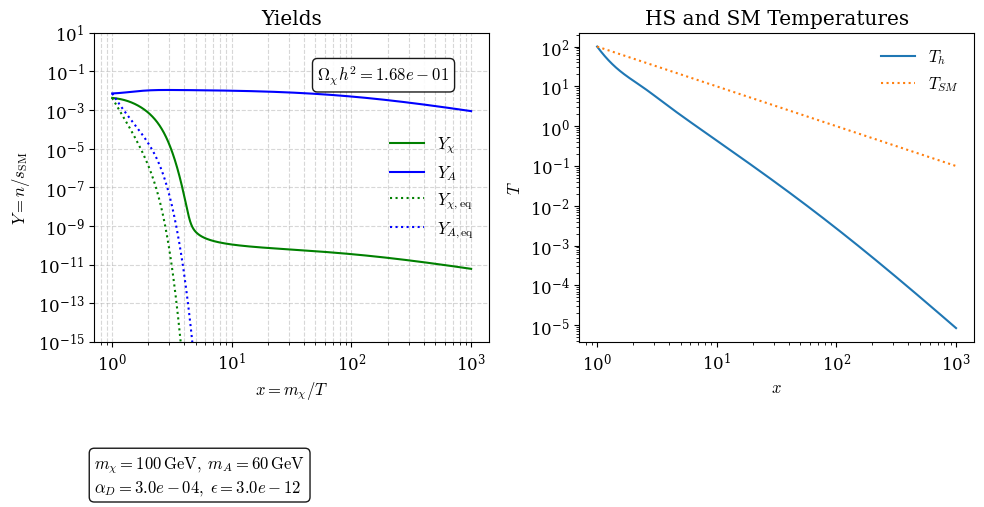

In [121]:
# Diagnostics: yields vs SM entropy
mchi = params["mchi"]
T = mchi/xs
Th = Th_evolve
Ychi = Y(nchi_evolve, T)
YA  = Y(nA_evolve,  T)
xs = x_evolve
Omega_h2 = get_relic_abundance(Ychi[-1], mchi)

Ychi_eq = Y(neq(mchi, gchi, Th), T)
YAp_eq  = Y(neq(mA,  gA,  Th), T)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].loglog(xs, Ychi, color = "green", label=r'$Y_\chi$')
ax[0].loglog(xs, YA, color = "blue", label=r'$Y_{A}$')

# plot equilibrium yields for comparison
ax[0].loglog(xs, Ychi_eq, ':',  color = "green", label=r'$Y_{\chi,{\rm eq}}$')
ax[0].loglog(xs, YAp_eq,  ':', color = "blue", label=r'$Y_{A,{\rm eq}}$')
ax[0].set_ylim(1e-15, 1e1)

ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields')

# add text annotation for model parameters
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
    #r"$\alpha_D = %.1e,\; \epsilon = %.1e$" "\n"
    #r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    #r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])
     #params["sv_xxee"] * Gev2_to_cm3s, params["sv_xxAA"]* Gev2_to_cm3s)
ax[0].text(
    0.0,-0.5, param_text,
    transform=ax[0].transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

# add text annotation for relic abundance
relic_text = r"$\Omega_\chi h^2 = %.2e$" % (Omega_h2)
ax[0].text(
    0.9,0.9, relic_text,
    transform=ax[0].transAxes,
    va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

ax[0].grid(True, which='both', ls='--', alpha=0.5)


#ax[1].loglog(xs, Th/T, label=r'$T_h/T$')
ax[1].loglog(xs, Th, label = r'$T_h$')
ax[1].loglog(xs, T, ':', label=r'$T_{SM}$')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$T$'); ax[1].legend(frameon=False)
ax[1].set_title('HS and SM Temperatures')



plt.tight_layout()
plt.show()